In [1]:
import numpy as np
import sys

sys.path.append('../')

from mandala.nodecore import Node
from mandala.nodecore import Variable

from mandala.autodiff import basic_math
from mandala.autodiff import autodiff

In [2]:
def linear_forward(x, W):
    y = np.matmul(x, W.T)
    return y


def linear_backward_W(x, gy):
    gW = np.matmul(gy.T, x)
    return gW


def linear_backward_x(W, gy):
    gx = np.matmul(gy, W)
    return gx


class LinearFunction(autodiff.AutoDiff):

    def forward(self, xs):
        x, W = xs
        y = Node(linear_forward, [x, W])
        return y

    def backward(self, xs, gy):
        x, W = xs
        gW = Node(linear_backward_W, [x, gy])
        gx = Node(linear_backward_x, [W, gy])
        return gx, gW


class Linear(object):
    def __init__(self, in_ch, out_ch):
        self.W = Variable(
            np.random.normal(0, 1 / out_ch, (out_ch, in_ch)).astype('f')
        )

    def __call__(self, x):
        return LinearFunction()([x, self.W])

In [3]:
def sum_forward(x):
    return np.sum(x)


def sum_backward(x, gy):
    return np.ones_like(x) * gy


class SumFunction(autodiff.AutoDiff):
    def forward(self, xs):
        x = xs[0]
        y = Node(sum_forward, [x])
        return y

    def backward(self, xs, gy):
        x = xs[0]
        gx = Node(sum_backward, [x, gy])
        return gx,


def _sum(x):
    return SumFunction()([x])

In [4]:
l0 = Linear( 5, 10)
l1 = Linear(10, 10)
l2 = Linear(10,  3)

In [5]:
# 真の係数
W = np.arange(15, dtype=np.float32).reshape(3, 5)
#W = np.zeros((3, 5), dtype=np.float32)

In [6]:
batchsize = 32
x = Variable(np.random.random((batchsize, 5)).astype(np.float32))
t = Variable(np.matmul(x.data, W.T))

In [7]:
h0 = l0(x)
h1 = l1(h0)
y  = l2(h1)
loss = (y - t) ** 2 / batchsize

In [8]:
loss.backward()

In [9]:
l0.W.grad.data

array([[ 2.0812593 ,  2.8726945 ,  2.3956895 ,  2.8611588 ,  2.6430728 ],
       [ 3.4596505 ,  4.795042  ,  4.013479  ,  4.793844  ,  4.4522533 ],
       [-3.6535277 , -5.0445976 , -4.209376  , -5.0275106 , -4.6479197 ],
       [-1.8047571 , -2.4613888 , -2.0334728 , -2.4282594 , -2.2111676 ],
       [ 4.074095  ,  5.6880183 ,  4.7882347 ,  5.7197933 ,  5.357381  ],
       [-1.7266023 , -2.3663478 , -1.9624603 , -2.3435693 , -2.146695  ],
       [ 0.63721997,  0.8922481 ,  0.75172025,  0.89778584,  0.84225976],
       [ 1.563499  ,  2.1629248 ,  1.8066161 ,  2.1576188 ,  1.9979944 ],
       [ 0.7824297 ,  1.1190827 ,  0.9587451 ,  1.1454577 ,  1.1005595 ],
       [-2.6270323 , -3.742128  , -3.1973395 , -3.8200407 , -3.6560192 ]],
      dtype=float32)

In [10]:
lr = 1e-3

for i in range(100):
    # make batch
    x = Variable(np.random.random((batchsize, 5)).astype(np.float32))
    t = Variable(np.matmul(x.data, W.T))
    
    # forward
    h0 = l0(x)
    h1 = l1(h0)
    y  = l2(h1)

    # loss
    loss = _sum((y - t) ** 2) / batchsize
    
    l0.W.grad = 0.
    l1.W.grad = 0.
    l2.W.grad = 0.

    # backward
    loss.backward()
    
    # update
    l0.W.data -= lr * l0.W.grad.data
    l1.W.data -= lr * l1.W.grad.data
    l2.W.data -= lr * l2.W.grad.data

    print(loss.data)

1269.27880859375
1473.388671875
1425.890869140625
1311.43896484375
1366.2716064453125
1281.0806884765625
1548.0069580078125
1247.4254150390625
1299.529296875
1221.3218994140625
1115.009033203125
1443.5118408203125
1345.06103515625
1155.745849609375
1129.7899169921875
1074.6612548828125
1441.25244140625
1246.7060546875
1358.5865478515625
1244.9775390625
1114.0244140625
1393.145263671875
887.5902099609375
1162.5235595703125
1005.1995849609375
826.2950439453125
904.306396484375
698.614990234375
487.99517822265625
186.46826171875
87.84376525878906
18.130390167236328
5.3416643142700195
3.5832109451293945
2.9579272270202637
1.657355546951294
2.847245216369629
2.6974411010742188
2.755253314971924
2.4614977836608887
2.4393930435180664
2.8534326553344727
1.8732962608337402
1.87569260597229
1.5564732551574707
2.4840707778930664
2.0936717987060547
1.493910551071167
2.05059552192688
1.9446985721588135
1.9508410692214966
1.724349021911621
2.249502658843994
1.9931418895721436
1.6056309938430786
1.70

In [11]:
y.data[0], t.data[0]

(array([ 6.085687, 21.1473  , 36.171135], dtype=float32),
 array([ 7.346419, 21.82301 , 36.299603], dtype=float32))

In [104]:
nodes = []

In [105]:
def get_node(y, nodes):
    nodes.append(y)
    for x in y.args:
        if x not in nodes:
            get_node(x, nodes)

In [106]:
l0.W.grad

In [80]:
get_node(l0.W.grad, nodes)
get_node(l1.W.grad, nodes)
get_node(l2.W.grad, nodes)

In [107]:
get_node(loss, nodes)

In [108]:
nodes

In [109]:
import itertools
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(nodes)

In [110]:
for node in nodes:
    for n0, n1 in itertools.permutations(nodes, 2):
        if not n1 in n0.args:
            continue
        if not G.has_edge(n0, n1):
            G.add_edge(n1, n0, weight=1)

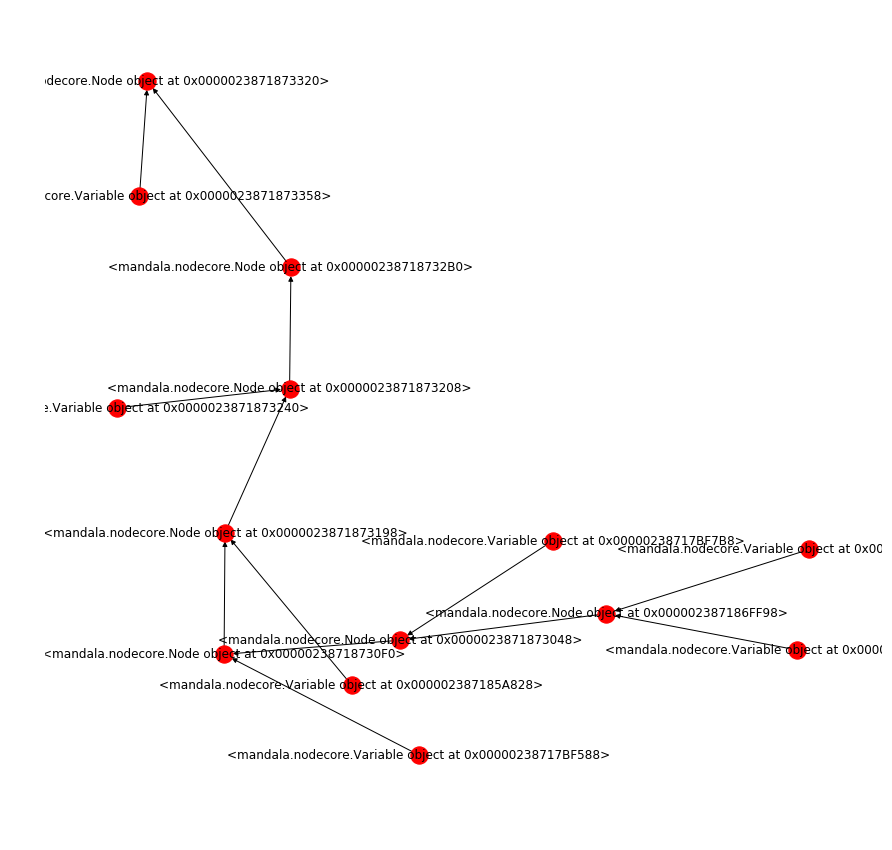

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)

plt.axis("off")
plt.savefig("default.png")
plt.show()